In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils

In [2]:
# Load results of the fitting procedure
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'full_midlevel'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) \
       for ss in subjects]
fig_save_folder=None

# initialize roi_def objects to get roi indices
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois



['leave_out_gabor_solo'
 'pyramid_texture_just_higher-level_plus_other_modules'
 'pyramid_texture_just_lower-level_plus_other_modules'
 'leave_out_sketch_tokens']
[791, 838, 295, 737]
[96, 49, 592, 150]


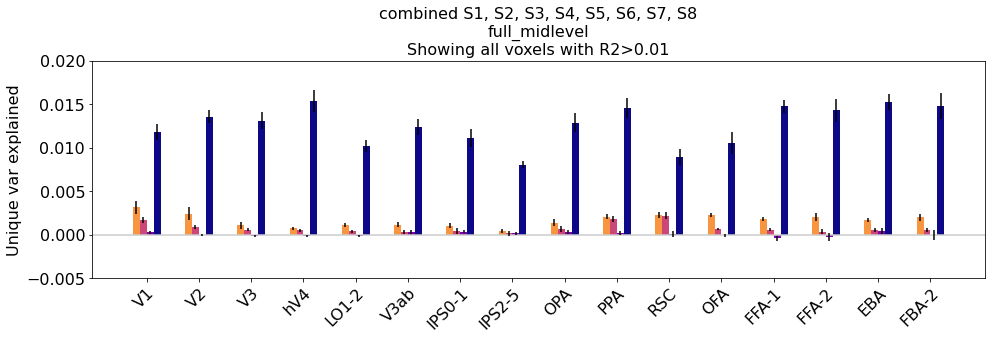

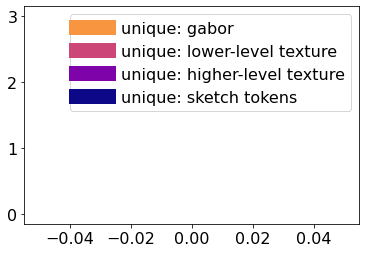

In [3]:
# Make a barplot for variance partition across all ROIs and subjects

r2_thresh = 0.01

# each of these indices is one feature set left out at a time.
ppinds = [2,8,7,10]
print(np.array(out[0]['partial_version_names'])[ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: lower-level texture', \
            'unique: higher-level texture','unique: sketch tokens']

colors = np.flipud(cm.plasma(np.linspace(0,1,5))[0:4,:])

vals = np.zeros((n_subjects, n_rois, 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    var_expl = np.tile(val_r2[:,0:1], [1,4]) - val_r2[:,ppinds]

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)
plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.005, 0.020], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


['leave_out_gabor_solo'
 'pyramid_texture_just_higher-level_plus_other_modules'
 'pyramid_texture_just_lower-level_plus_other_modules'
 'leave_out_sketch_tokens']
[791, 838, 295, 737]
[96, 49, 592, 150]


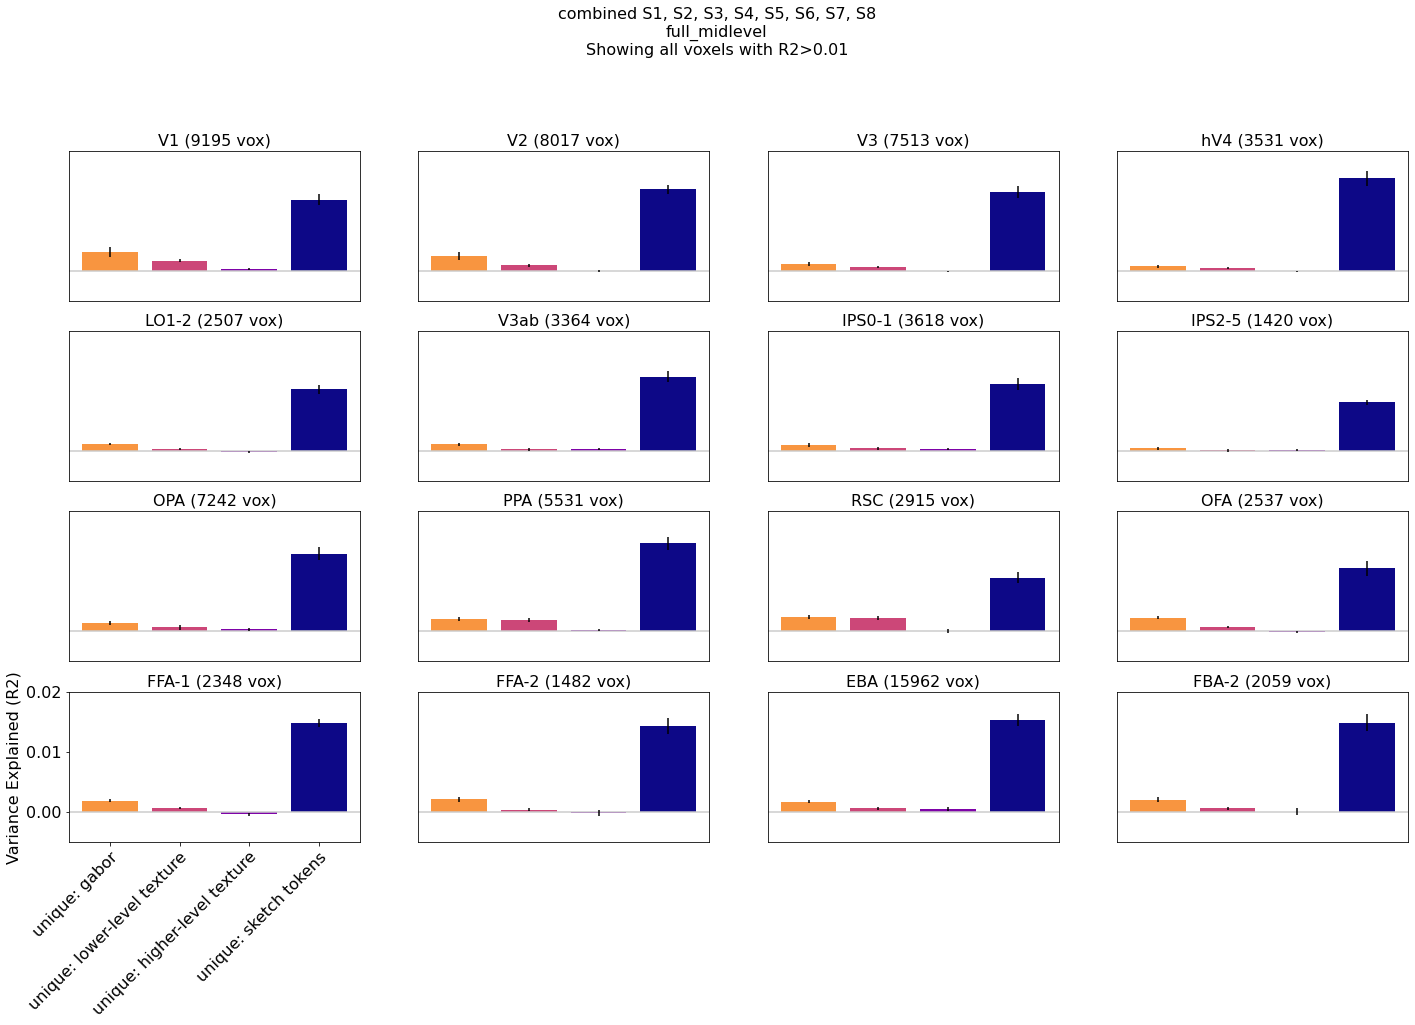

In [4]:

# each of these indices is one feature set left out at a time.
ppinds = [2,8,7,10]
print(np.array(out[0]['partial_version_names'])[ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: lower-level texture', \
            'unique: higher-level texture','unique: sketch tokens']
val_r2 = np.concatenate([o['val_r2'] for o in out],axis=0)
var_expl = np.tile(val_r2[:,0:1], [1,4]) - val_r2[:,ppinds]

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])

colors = cm.plasma(np.linspace(0,1,5))[0:4,:]
colors = np.flipud(colors)

r2_thresh = 0.01
inds2use = val_r2[:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                    horizontal_line_pos=0, ylims=[-0.005, 0.020])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, roi_def=roi_def,\
                               subject_inds=subject_inds, 
                    suptitle='%s\n%s\nShowing all voxels with R2>%.2f'%\
                               (summary_plots.get_substr(out), fitting_type, r2_thresh))
plt.gcf().subplots_adjust(bottom=0.4)


['just_gabor_solo' 'pyramid_texture_just_lower-level_no_other_modules'
 'pyramid_texture_just_higher-level_no_other_modules'
 'just_pyramid_texture' 'just_sketch_tokens']


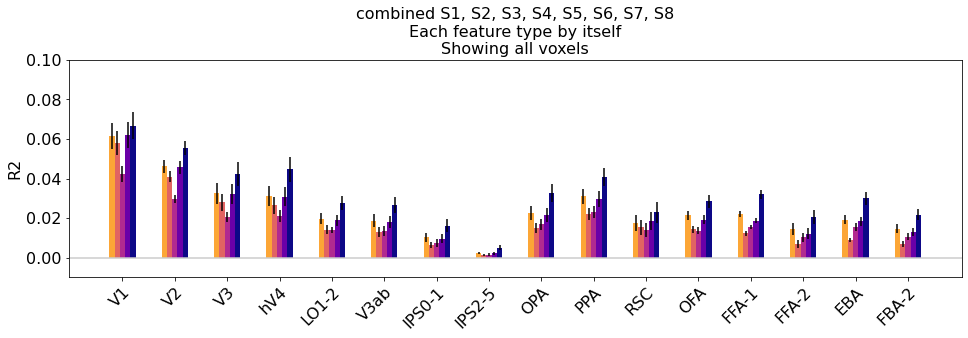

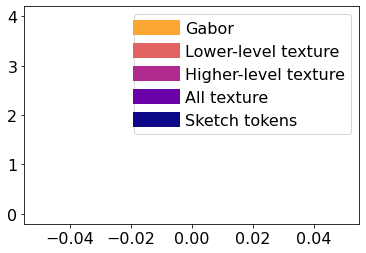

In [6]:
# Plot performance of each feature type when fit alone.

ppinds = [1,5,6,3,9]
print(np.array(out[0]['partial_version_names'])[ppinds])
names = ['Gabor','Lower-level texture', 'Higher-level texture','All texture','Sketch tokens']

colors = np.flipud(cm.plasma(np.linspace(0,1,6))[0:5,:])

vals = np.zeros((n_subjects, n_rois, 5))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    r2_alone = val_r2[:,ppinds]
    
    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri)
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(r2_alone[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\nEach feature type by itself\nShowing all voxels'%(summary_plots.get_substr(out))

plot_utils.set_all_font_sizes(fs = 16)
plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.10], title=title, horizontal_line_pos=0,\
                legend_labels=names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


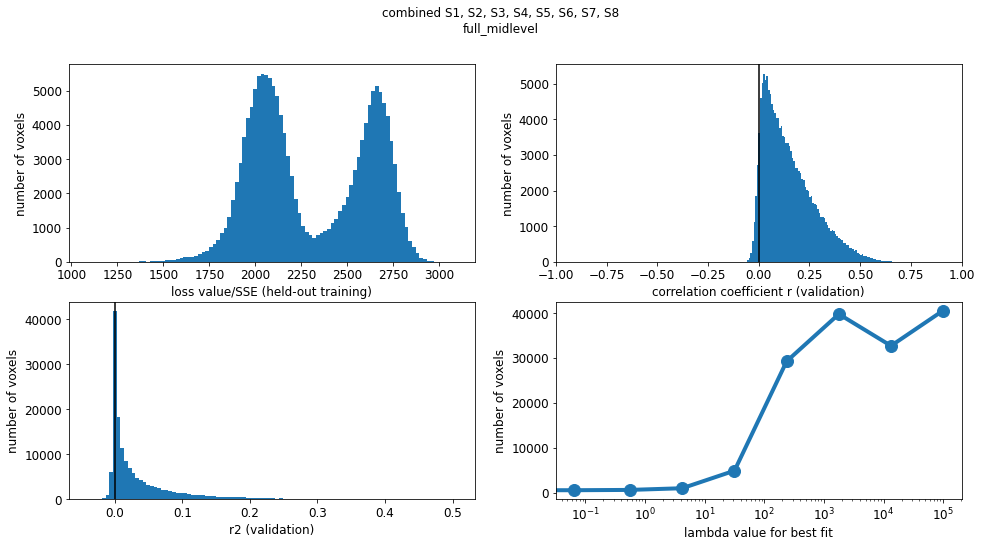

In [22]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(fitting_type, out)

In [26]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_summary_pycortex(fitting_type, out, port=44442, roi_def=roi_def)

navigate browser to: 127.0.0.1:44442
Started server on port 44442
Stopping server


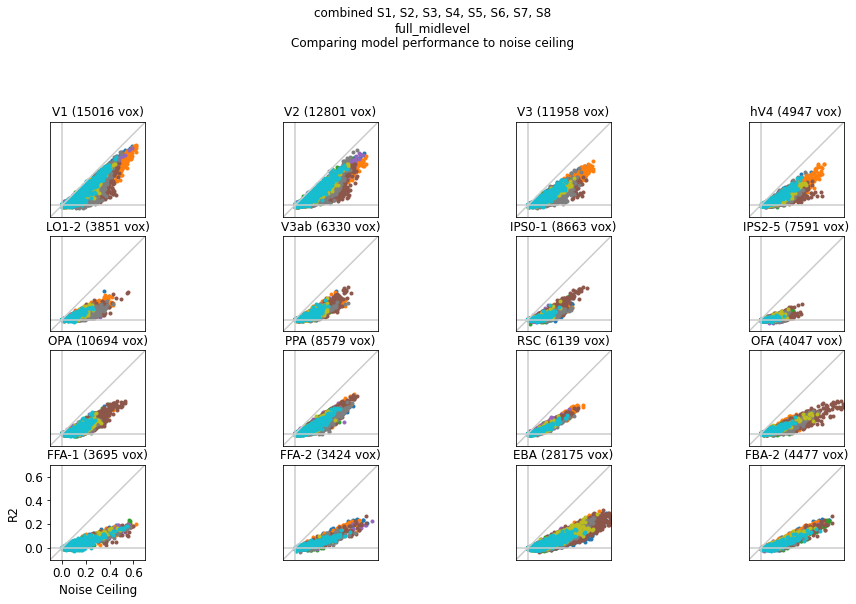

In [4]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_r2_vs_nc(fitting_type, out, roi_def)